# Airbnb Rio de Janeiro - Análise exploratória

# 1. Introdução

Este estudo tem como objetivo realizar uma Análise Exploratória de Dados (EDA) do [anúncio de imóveis do Airbnb na cidade do Rio de Janeiro](https://insideairbnb.com/get-the-data/#:~:text=Rio%20de%20Janeiro%2C%20Rio%20de%20Janeiro%2C%20Brazil). Os dados correspondem à data de 27 de Junho de 2024, correspondente à coleta de dados mais recente disponível no momento da elaboração deste estudo. 

Através desta análise, buscamos identificar variáveis que influenciam os preços, tendências e insights que possam ser úteis para ambos anfitriões e hóspedes.

## 1.1 Configurações e bibliotecas

In [56]:
from PIL import Image
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('..'))

from summarytools import dfSummary

from rio_airbnb.features import PreProcessamento, SepararOutliersIQR, RemoverFeaturesCorrelacionadas
from rio_airbnb.plots import AjusteDistribuicoes, MatrizCorrelacao, ImpactoVariaveisQuantitativas, ImpactoVariaveisQualitativas, MapaMedianaPrecos

## 1.2 Dados utilizados

Dos dados disponíveis no site, utilizaremos apenas *[listings.csv.gz](https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2024-06-27/data/listings.csv.gz)*. Esse arquivo contém informações detalhadas dos imóveis na cidade e período considerados.

In [9]:
df_inicial = pd.read_parquet('../data/bronze/listings_train.parquet')

## 1.3 Dicionário de dados

O dicionário de dados oficial em inglês pode ser encontrado nessa [planilha Google Sheets](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?pli=1&gid=1322284596#gid=1322284596).

| Campo                                       | Tipo     | Descrição                                                                                          |
|---------------------------------------------|----------|----------------------------------------------------------------------------------------------------|
| accommodates                                | integer  | Número máximo de hóspedes                                                                          |
| amenities                                   | text     | Lista de amenidades oferecida                                                                      |
| availability_30                             | integer  | Número de dias disponíveis nos próximos 30 dias                                                    |
| availability_365                            | integer  | Número de dias disponíveis nos próximos 365 dias                                                   |
| availability_60                             | integer  | Número de dias disponíveis nos próximos 60 dias                                                    |
| availability_90                             | integer  | Número de dias disponíveis nos próximos 90 dias                                                    |
| bathrooms                                   | float    | Número de banheiros                                                                                |
| bathrooms_text                              | text     | Descrição dos banheiros                                                                            |
| bedrooms                                    | integer  | Número de quartos                                                                                  |
| beds                                        | integer  | Número de camas                                                                                    |
| calendar_last_scraped                       | datetime | Data da última coleta no período                                                                   |
| calendar_updated                            | text     | Data da última atualização no período                                                              |
| calculated_host_listings_count              | integer  | Número calculado de anúncios do anfitrião                                                          |
| calculated_host_listings_count_entire_homes | integer  | Número calculado de anúncios de casas inteiras do anfitrião                                        |
| calculated_host_listings_count_private_rooms| integer  | Número calculado de anúncios de quartos privados do anfitrião                                      |
| calculated_host_listings_count_shared_rooms | integer  | Número calculado de anúncios de quartos compartilhados do anfitrião                                |
| description                                 | text     | Descrição do anúncio                                                                               |
| first_review                                | datetime | Data da primeira avaliação                                                                         |
| has_availability                            | boolean  | Indica se o lugar tem disponibilidade                                                              |
| host_about                                  | text     | Descrição sobre o anfitrião                                                                        |
| host_acceptance_rate                        | text     | Taxa de aceitação da hospedagem                                                                    |
| host_has_profile_pic                        | boolean  | Indica se o anfitrião possui foto de perfil                                                        |
| host_id                                     | integer  | Identificador único do anfitrião                                                                   |
| host_identity_verified                      | boolean  | Indica se a identidade do anfitrião foi verificada                                                 |
| host_is_superhost                           | boolean  | Indica se o anfitrião é um superhost                                                               |
| host_listings_count                         | integer  | Número de anúncios do anfitrião                                                                    |
| host_location                               | text     | Localização do anfitrião                                                                           |
| host_name                                   | text     | Nome do anfitrião                                                                                  |
| host_neighbourhood                          | text     | Bairro do anfitrião                                                                                |
| host_picture_url                            | text     | URL da imagem do anfitrião                                                                         |
| host_response_rate                          | text     | Taxa de resposta do anfitrião                                                                      |
| host_response_time                          | text     | Tempo de resposta do anfitrião                                                                     |
| host_since                                  | datetime | Data de cadastro do anfitrião                                                                      |
| host_thumbnail_url                          | text     | URL da imagem em miniatura do anfitrião                                                            |
| host_total_listings_count                   | integer  | Número total de anúncios do anfitrião                                                              |
| host_url                                    | text     | URL do perfil do anfitrião                                                                         |
| host_verifications                          | text     | Verificações do anfitrião                                                                          |
| id                                          | integer  | Identificador único do anúncio                                                                     |
| instant_bookable                            | boolean  | Indica se a anúncio pode ser reservada instantaneamente                                            |
| last_review                                 | datetime | Data da última avaliação                                                                           |
| last_scraped                                | datetime | UTC. A data e hora em que este anúncio foi raspado                                                 |
| latitude                                    | float    | Latitude da localidade                                                                             |
| license                                     | text     | Número da licença ou permissão para operar                                                         |
| listing_url                                 | text     | URL do anúncio                                                                                     |
| longitude                                   | float    | Longitude da localidade                                                                            |
| maximum_maximum_nights                      | integer  | Valor máximo do número máximo de noites nos próximos 365 dias                                      |
| maximum_minimum_nights                      | integer  | Valor máximo do número mínimo de noites nos próximos 365 dias                                      |
| maximum_nights                              | integer  | Número máximo de noites para estadia                                                               |
| maximum_nights_avg_ntm                      | float    | Média do valor máximo de noites nos próximos 365 dias                                              |
| minimum_maximum_nights                      | integer  | Valor mínimo do número máximo de noites nos próximos 365 dias                                      |
| minimum_minimum_nights                      | integer  | Valor mínimo do número mínimo de noites nos próximos 365 dias                                      |
| minimum_nights                              | integer  | Número mínimo de noites para estadia                                                               |
| minimum_nights_avg_ntm                      | float    | Média do valor mínimo de noites nos próximos 365 dias                                              |
| name                                        | text     | Nome da anúncio                                                                                    |
| neighbourhood                               | text     | Bairro com base em dados do Airbnb                                                                 |
| neighbourhood_cleansed                      | text     | Bairro com base em dados públicos                                                                  |
| neighbourhood_group_cleansed                | text     | Grupo de bairros com bas em dados públicos                                                         |
| neighbourhood_overview                      | text     | Descrição do bairro pelo anfitrião                                                                 |
| number_of_reviews                           | integer  | Número de avaliações                                                                               |
| number_of_reviews_l30d                      | integer  | Número de avaliações nos últimos 30 dias                                                           |
| number_of_reviews_ltm                       | integer  | Número de avaliações nos últimos 12 meses                                                          |
| picture_url                                 | text     | URL da imagem principal da anúncio                                                                 |
| price                                       | currency | Preço diário em moeda local.                                                                       |
| property_type                               | text     | Tipo de propriedade                                                                                |
| review_scores_accuracy                      | float    | Pontuação de precisão das avaliações                                                               |
| review_scores_checkin                       | float    | Pontuação de check-in das avaliações                                                               |
| review_scores_cleanliness                   | float    | Pontuação de limpeza das avaliações                                                                |
| review_scores_communication                 | float    | Pontuação de comunicação das avaliações                                                            |
| review_scores_location                      | float    | Pontuação de localização das avaliações                                                            |
| review_scores_rating                        | float    | Pontuação média das avaliações                                                                     |
| review_scores_value                         | float    | Pontuação de valor das avaliações                                                                  |
| reviews_per_month                           | float    | Número médio de avaliações por mês                                                                 |
| room_type                                   | text     | [Tipo de quarto](https://www.airbnb.com/help/article/5)                                            |
| scrape_id                                   | bigint   | Identificador da raspagem dos dados                                                                |
| source                                      | text     | Encotnrado por uma raspagem anterior ou por busca regional                                         |

## 1.4 Sumarização

Excluiremos algumas variáveis que não trazem valor à nossa análise. Também faremos algumas transformações preliminares.
- Datas do primeiro e último review são substituidas pelo intervalo em dias até a data da raspagem de dados. Uma variável binária extra 'was_reviewed' indica se a localidade foi avaliada anteriormente;
- Descrições são substituídas por sua contagem de caracteres;
- Expandir os modos de verificação do host para colunas diferentes;
- Substituição da lista de amenidades por sua contagem;
- Preço convertido para valores numéricos;

In [19]:
df_sumarizacao = PreProcessamento().fit_transform(df_inicial)
dfSummary(df_sumarizacao)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,accommodates[int64],Mean (sd) : 4.0 (2.3)min < med < max:1.0 < 4.0 < 16.0IQR (CV) : 3.0 (1.7),16 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACz0lEQVR4nO3dvY7aQBRA4TuwEPNnC4igo0nHSim25AFS7sPuIwSJIiWhTUWDkBAywTFiMKRI0q0A2xDPRefrB1wc767nasfmdDoJ4LpS0RcAXOOp6As4xxhTE5FqxuX70+kU3/J6UBxnQzXG1Lrd7qvv++0s6zebzdoY80asj8HZUEWk6vt+ezQaxUEQ7NIsDMPQm0wm7dVqVRURQn0ALocqIiJBEOx6vd6vDEtrN78YFIaHKahAqFCBUKECoUIFQoUKhAoVCBUqECpUuLjhz7wdLjgbKvN2uOLST1Tm7XDCVbN+5u0oGg9TUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSrc9RWTSZJURMQ3xmRZ7h+Px8qNLwlK3S3UKIoq1trPg8GgXC6XUx0CLCJirfWSJHne7XZfRST12aw5bxIRjnV3yt1C3e/3T57n1V9eXnb9fn+ddv18Pm/PZrP64XAop12b9yYR4Vh319z97dKNRiPTadXr9TrzadV5bxKOdXeP869BzyPrTfIXx7o7hKd+qECoUIFQoQKhQgVChQqEChUIFSo89D5qHjlHsIxfb4xQ35F3BMv49fYI9R15RrCMX++DUM/IMYJl/HpjPExBBUKFCvzqd4wxpiYi1Rwf8ZA7DoTqEGNMrdvtvvq+3876GUXuOOS8yc7eYIR6Bzn2YP1ms9kbjUabIAhSb4uFYeiNx+PearX6aIzZpF0vf/4UPGZYJyLidTqdL0EQNLIsvnSDXRVqGIZe2i/ebreeiEgURd5yuaz/z/VFfvdisWhl3YP9939i1tpvIpI61DiOM+//JklSiaLoU7PZ/FEqlWza77bWeiLyPBwOv7darZ9p1sZx/GE6nZ7d0vsN7NE8cP+IF6cAAAAASUVORK5CYII="">",0(0.0%)
2,availability_30[int64],Mean (sd) : 20.2 (10.9)min < med < max:0.0 < 26.0 < 30.0IQR (CV) : 18.0 (1.9),31 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACw0lEQVR4nO3dsU7bUBiG4f8kJHIIOkchadhYOiJ1iMSSC+jIxXIJIGXozNClExuSFdnCYMXY6dJKSFUgtgnpF73PGv22xXkTx5whbr1eG/C/6+z7AoBtHO37AnA4nHMDM+s3HF+t1+vnTS8SKj6Ec24wHo+vvPejJvNpmi6dc9ebYiVUfJS+9340n8+fQwh5ncEkSaLFYjGK47hvZoSK3Qsh5NPp9KnB6OCtF3mYggRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChYR3f13aOTcws37D4682/f46UMeboTrnBuPx+Mp7P2py8DRNl865a2JFW+99ova996P5fP4cQsjrHDhJkmixWIziOO6bGaGilXdv/WZmIYR8Op0+NTj+oMEM8A8epiCBUCGBUCGBUCGBUCFhq6d+6DjUDRpCPSCHvEFDqIel1QbN7e3tNI7jiXMubXBuX1VVr8HcVgh1g5a30I6ZVXuY9VVV9UIIy7obNFmW9Yqi+HZ+ft7tdru1IjczK4oiKsvyIs/zGzNrsjn0pp2GWpZlz8y8c67pIfa14NHp6en3EMKw7mBZlr0sy76enJz86nQ6xWfNmrWLZbVaHUVRdDybzfKzs7Nl3XPf39+P7u7ujl9eXrp1Z7exs1DbvkP3veBmdnF5efljMpnUug3+WbAvs9nsZ90FbzP7ar5VLMPhsNF2+XK53Ol2+c5C/aB36F4XPIqiou6i/V2wJgveZvb1/CHa+XfUtn90Fhxm/MMfIrb6RE2SJKp74MfHx8jMLMuy6OHh4fgz51XPrXrdbee36es3UPtpn0q2/aoAAAAASUVORK5CYII="">",0(0.0%)
3,availability_365[int64],Mean (sd) : 205.7 (114.6)min < med < max:0.0 < 193.0 < 365.0IQR (CV) : 232.0 (1.8),366 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACg0lEQVR4nO3bTYriQBiH8bfGVqJCgjTozgsMzMKlh5jDzhFm4Qm8gTtBJGKmg/Fj1gN+JtZU/cPz20p11+LBvIkVd7lcDIjdt9AbAJ7xEXoDaA/nXN/MejWXHy6Xy9etDwkVb+Gc639+fv5M03RUZ/1ut9s6537dipVQ8S69NE1H8/n8K8uy8pWFeZ4ni8VitNlsemZGqPAvy7JyPB7/qbG0f+9DbqYggVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhIep3pny+fgst0Ybq+/VbaIk2VPP8+i20xByqmfl7/RZauJmCBEKFBEKFhOhn1FB4NBYXQr2CR2PxIdTreDQWGUK9Q/HRWFtHFkJtkTaPLITaLq0dWQi1hRRHlkd4jgoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJXn9CbXiSJz2fz9137ge6vIXa9CRPVVXJ6XT6XpblbzOr87s1WsTnN2rtkzxmZqvVarRcLgfH47HjY3PQ8jDUBpfv9Hw+d7Ms29Y5ybPdbhud5DmdTl0zS51zdZYHGzsYl667G2qTy3fIS3dRFN2qqn5Mp9NOp9N5+ds81N4Zl2579I1a+/Id8tJ9OBw+kiQZzGazcjKZbF9dH3DvjEs3PDWj1jmI2/TS/Q7D4bDWAeLQe6978Dn0vn3ihL8HDebj1s6YTRHqmzWZj0PPmDHfgBLqmzWZj0POmLHfgBKqJ3Xm45AzZuw3oISKf8R6A8qhFEggVEggVEggVEggVEggVEggVEggVEh46oF/nufJq394v98nZmZFUSTr9XrwP9er/m/VfTdd/0xffwHXXKj5cWeWVAAAAABJRU5ErkJggg=="">",0(0.0%)
4,availability_60[int64],Mean (sd) : 43.9 (19.8)min < med < max:0.0 < 

# 2. Análise da variável resposta

Eliminamos valores nulos na variável resposta e separamos o conjunto em dois utilizando o método de intervalo interquantílico. No restante desse estudo, trataremos dos dados não identificados como outliers. Recomenda-se a análise do conjunto dos outliers em um estudo posterior.

O preço máximo após a remoção dos outliers é de 1125.

Muito embora a melhor distribuição seja a genextreme, por motivos de simplicidade, utilizaremos a distribuição gama para modelarmos o preço.

Tamanho do dataset sem outliers: 24255
Tamanho do dataset de outliers: 2702
Preço máximo após remoção de outliers: 1125.0


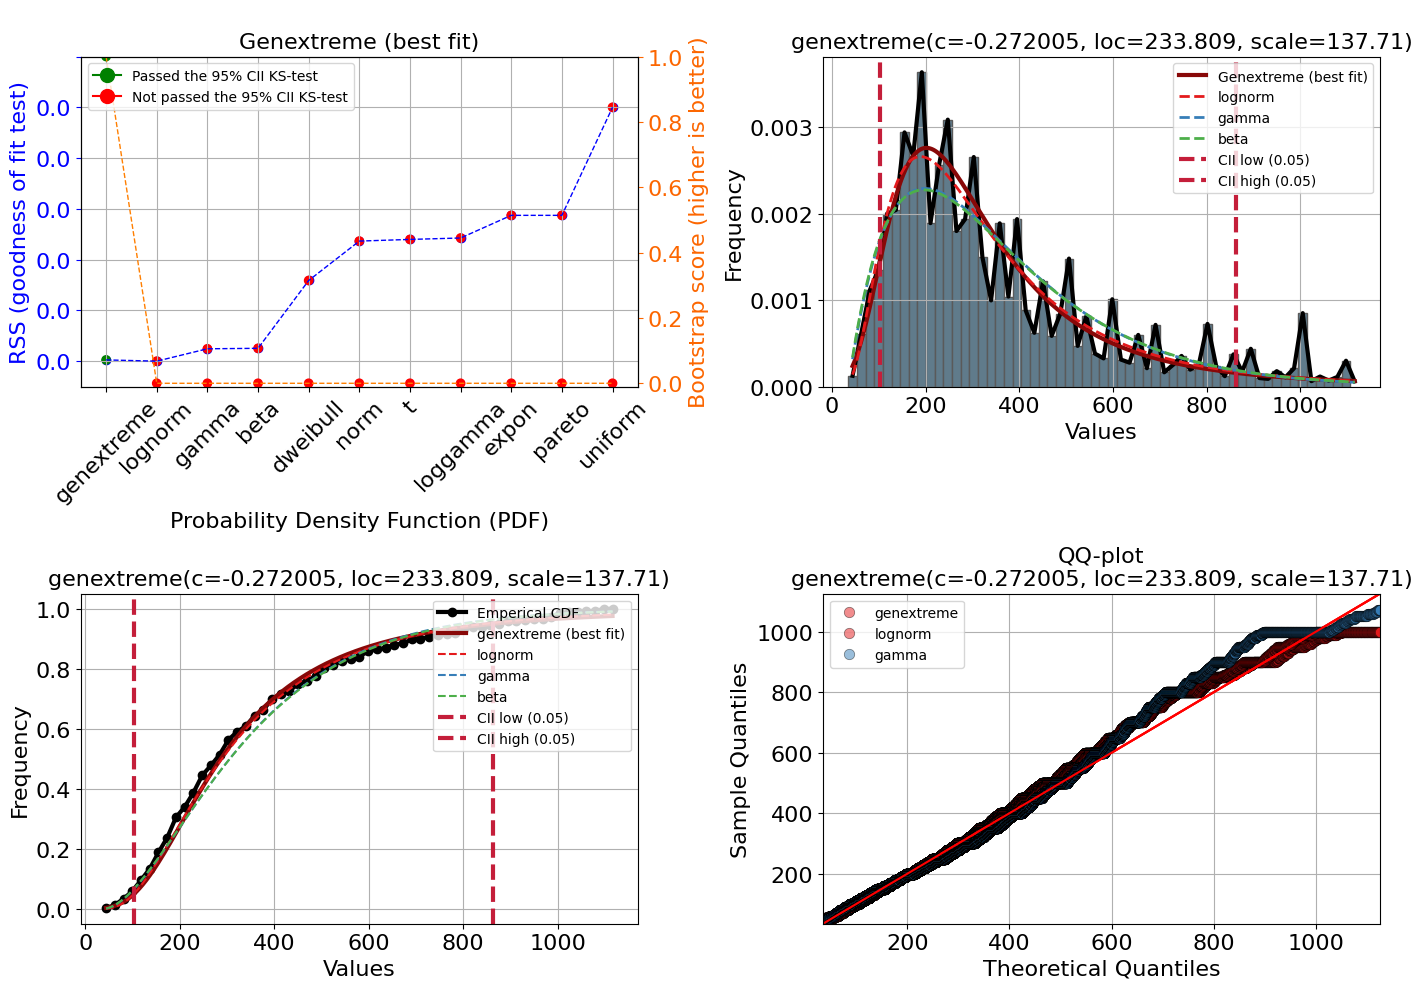

In [25]:
# Separar o DataFrame em dois: sem outliers (e sem preços iguais a zero) e com outliers
separador_outliers = SepararOutliersIQR(coluna='price')
df_sem_outliers = separador_outliers.fit_transform(df_sumarizacao)
df_com_outliers = separador_outliers._get_outliers()

# Tamanho e preço máximo depois da filtragem
print(f"Tamanho do dataset sem outliers: {df_sem_outliers.shape[0]}")
print(f"Tamanho do dataset de outliers: {df_com_outliers.shape[0]}")
print(f"Preço máximo após remoção de outliers: {df_sem_outliers['price'].max()}")

AjusteDistribuicoes(coluna='price').processar_e_plotar(df_sem_outliers)

## 3. Correlação entre as variáveis

Esse dataset contém variáveis de diversos tipos. Usaremos a matriz de correlação proposta pela biblioteca [_dython_](https://shakedzy.xyz/dython/modules/nominal/).
Ela utiliza diferentes estratégias para mensurar a associação entre as variáveis dependendo dos tipos envolvidos:

- Caso contínuo-contínuo: [Correlação de Spearman](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient);
- Caso categórico-contínuo: [Coeficiente de correlação](https://en.wikipedia.org/wiki/Correlation_ratio);
- Caso categórico-categórico: [V de Cramér](https://www.statstest.com/cramers-v-2/).

Eliminaremos sistematicamente variáveis explicativas que tenham alta correlação entre si: abaixo de -0.8 e acima de 0.8.


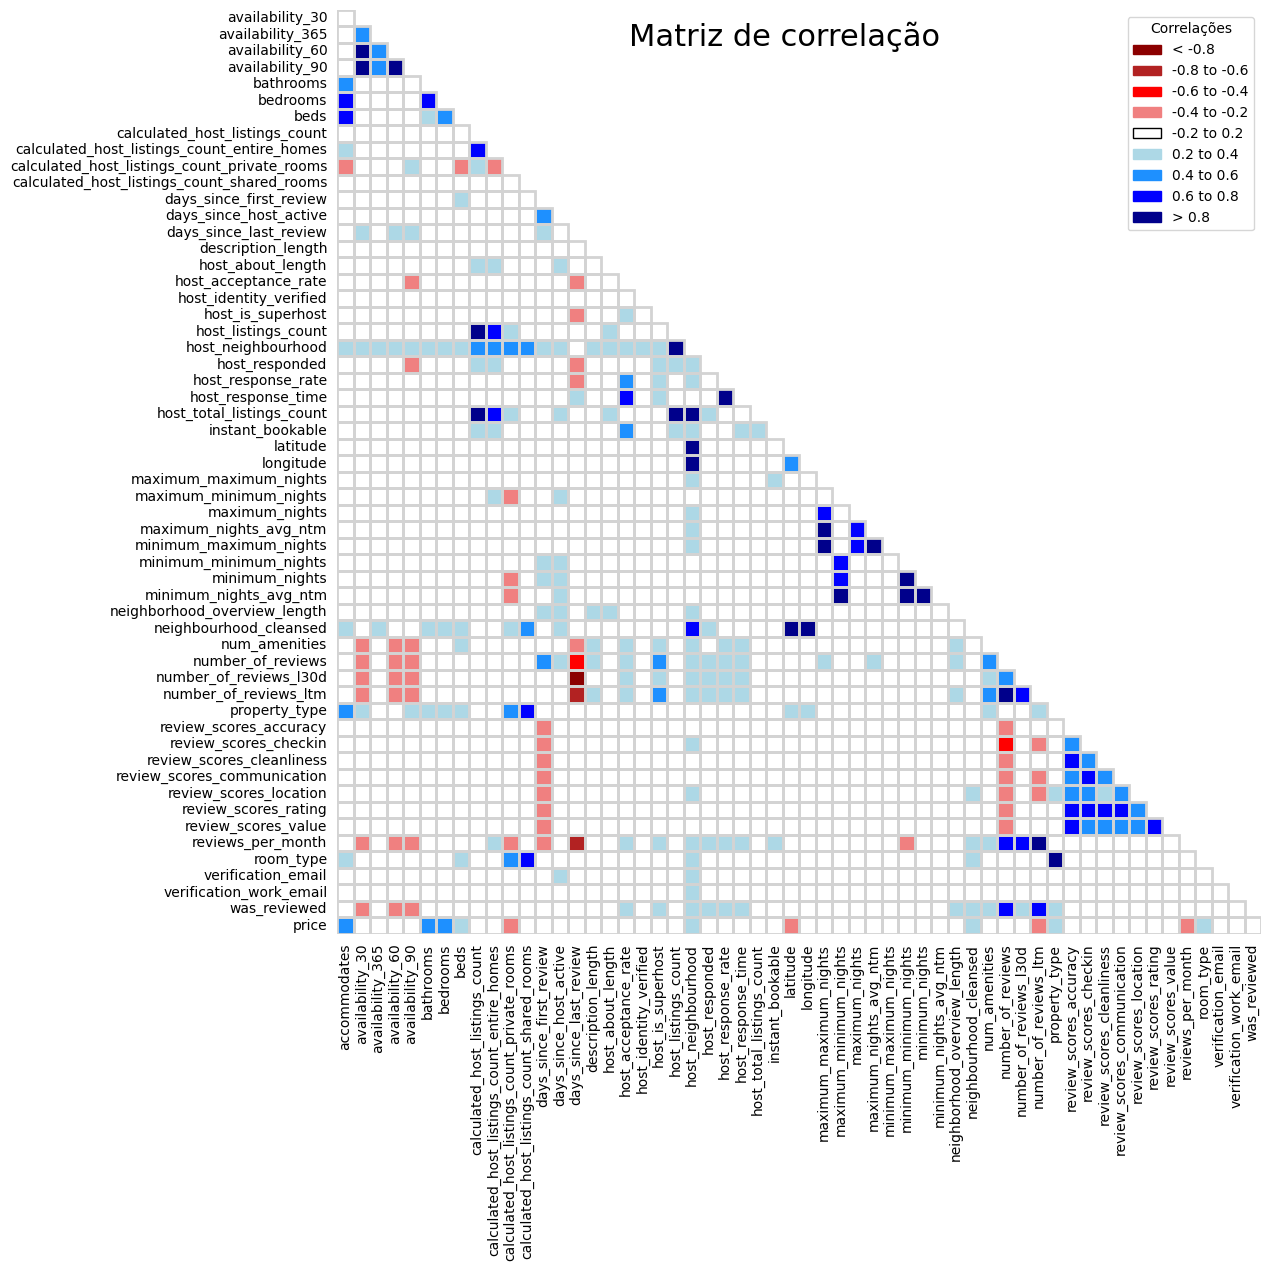

In [34]:
MatrizCorrelacao(df_sem_outliers, 'price').gerar()
df_correlacao = RemoverFeaturesCorrelacionadas(salvar=True).fit_transform(df_sem_outliers)

# 4. Análise multivariada

Analisaremos a relação da variável resposta preço com as variáveis explicativas.

## 4.1 Preço vs variáveis quantitativas

- `number_of_reviews`: Existe uma tendência de que, quanto maior o número de avaliações, menor é o preço. Isso pode sugerir que propriedades com preços mais baixos atraem mais hóspedes e são mais avaliadas
- `review_scores_rating`: A maioria dos pontos está concentrada em notas altas (4 a 5) e essas propriedades têm uma grande variação de preços, incluindo preços altos. Propriedades com notas mais baixas tendem a serem mais baratas
- `reviews_per_month`: Há uma tendência de que, quanto maior o número de avaliações por mês, menor é o preço
- `calculated_host_listings_count_private_rooms`: A maioria das propriedades com muitos quartos privados tem preços relativamente baixos. Propriedades com poucos quartos privados (0 a 5) têm uma maior variação de preços. Pode indicar que hosts que listam muitas propriedades privadas tendem a oferecer preços mais competitivos

Parece não haver uma relação clara entre a variável resposta e as demais variáveis.

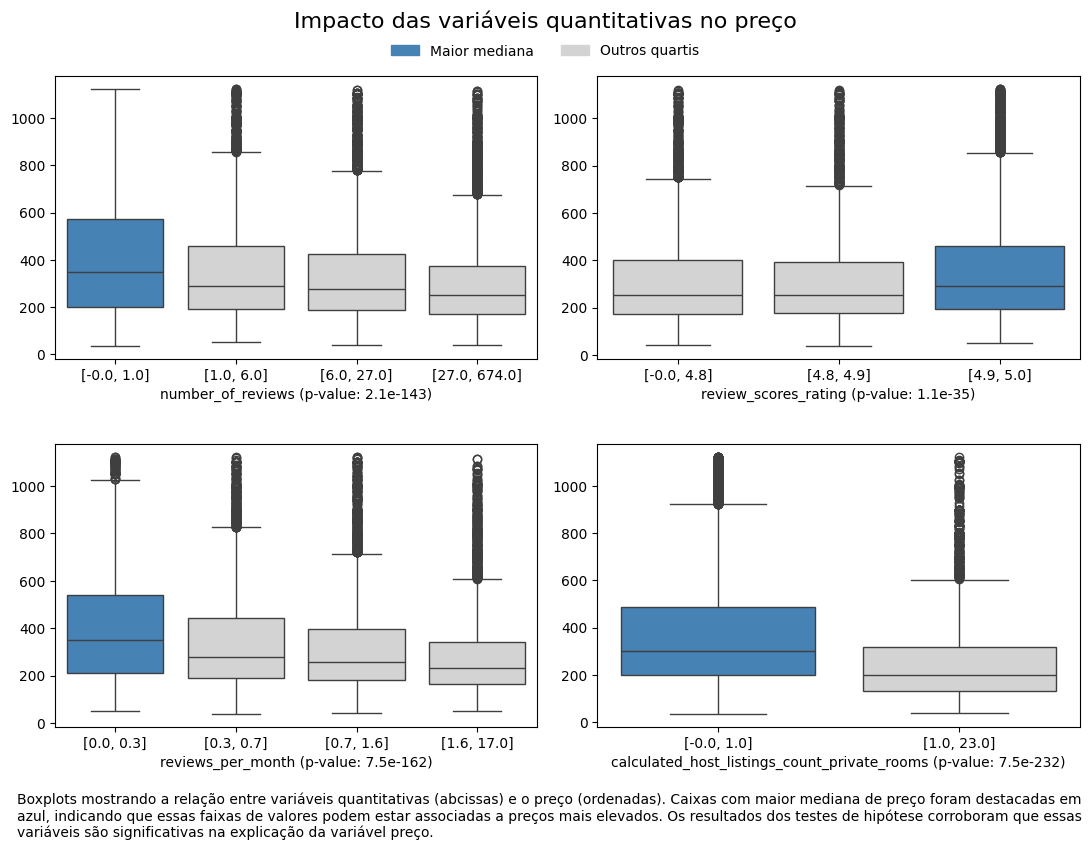

In [57]:
# Definir as variáveis quantitativas que queremos analisar
variaveis_quantitativas = ['number_of_reviews', 'review_scores_rating', 'reviews_per_month', 
                           'calculated_host_listings_count_private_rooms']

# Texto explicativo personalizado
texto_explicativo = (
    "Boxplots mostrando a relação entre variáveis quantitativas (abcissas) e o preço (ordenadas). "
    "Caixas com maior mediana de preço foram destacadas em azul, indicando " 
    "que essas faixas de valores podem estar associadas a preços mais elevados. "
    "Os resultados dos testes de hipótese corroboram que essas variáveis são "
    "significativas na explicação da variável preço."
)

ImpactoVariaveisQuantitativas(df_correlacao, 'price', variaveis_quantitativas, texto_explicativo).plot()

Podemos observar três focos com mediana de preços mais altos:
- **Zona Sul (Copacabana, Ipanema, Leblon):** Preços mais altos, concentrados em áreas turísticas e costeiras.
- **Barra da Tijuca:** Da mesma forma, com preços mais altos, concentrados em áreas turísticas e costeiras.
- **Barra Olímpica:** Mais novo bairro do Rio de Janeiro, recebeu investimentos significativos durante as Olimpíadas de 2016.

A medida que nos afastamos das praias e pontos de interesse turísticos, os preços tendem a diminuir.

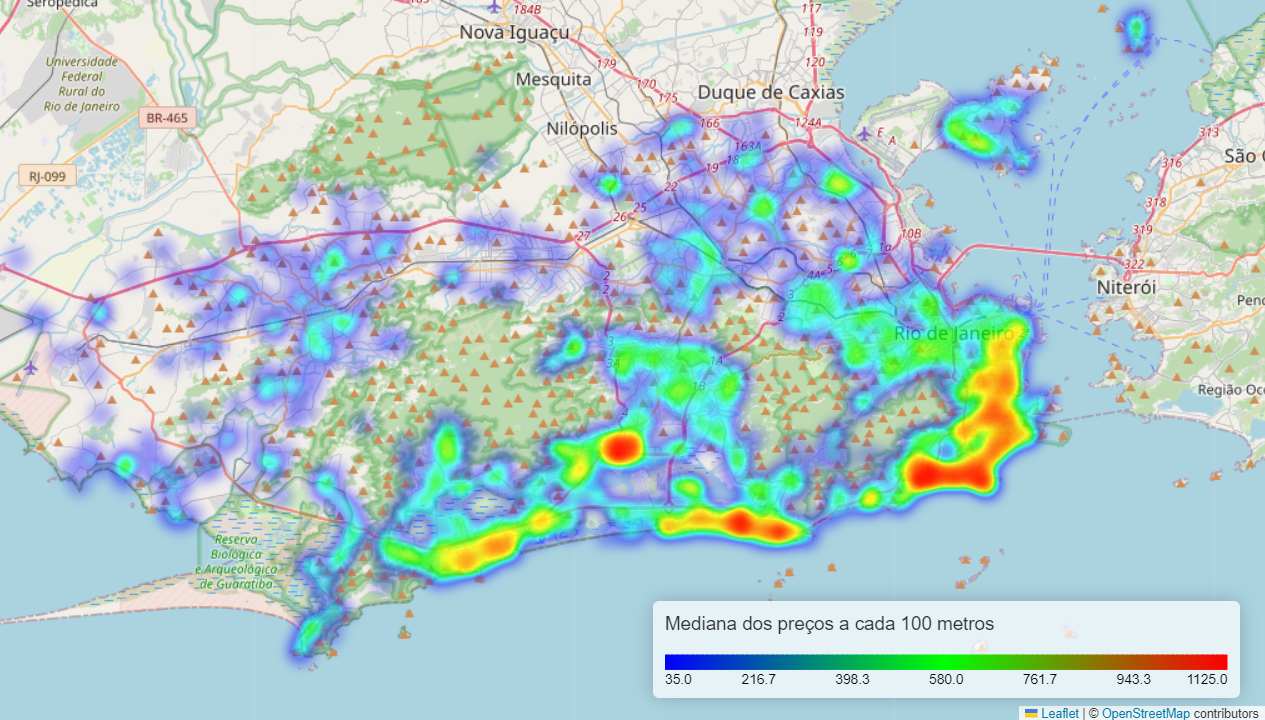

In [52]:
# MapaMedianaPrecos(df_correlacao, tamanho_grade=0.001).gerar() # Exibir o mapa interativo
Image.open('../references/rio_heatmap.png') # Importar a imagem do mapa ao invés de usar o mapa interativo

### 4.2 Preço vs variáveis categóricas

Para cada variável qualitativa, dependendo do número de categorias, aplica-se um teste de hipótese adequado: o teste de [Mann-Whitney](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) para comparar duas categorias, ou o teste de [Kruskal-Wallis](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_test) para três ou mais categorias. As categorias abaixo passaram no teste de hipótese e, portanto, temos evidência que a mediana é diferente em pelo menos uma das categorias.

- `room_type`: Casas/apartamentos inteiros têm os preços médios mais altos, seguidos por quartos de hotel, quartos privados e quartos compartilhados
- `host_identity_verified`: Hosts com identidade não verificada tem preços médios maiores
- `host_is_superhost`: Hosts que atenderam o critério de superhost tem preços médios menores
- `host_responded`: Hosts que nunca responderam clientes tem preços maiores
- `host_response_time`: O preço médio mais alto dentre as categorias acontece quando o host responde dentro de algumas horas. O preço mais baixo quando o host responde dentro de uma hora.
- `instant_bookable`: Preços médios são ligeiramente mais altos para propriedades que não são reserváveis de imediato
- `verification_work_email`: Hosts com emails profissionais verificados cobram preços médios mais altos
- `verification_email`: Hosts com emails verificados cobram preços médios ligeiramente mais altos
- `verification_phone`: Hosts com telefone não verificado têm preços médios mais altos do que aqueles com telefone verificado
- `was_reviewed`: Hosts que nunca foram avaliados tem preços menores

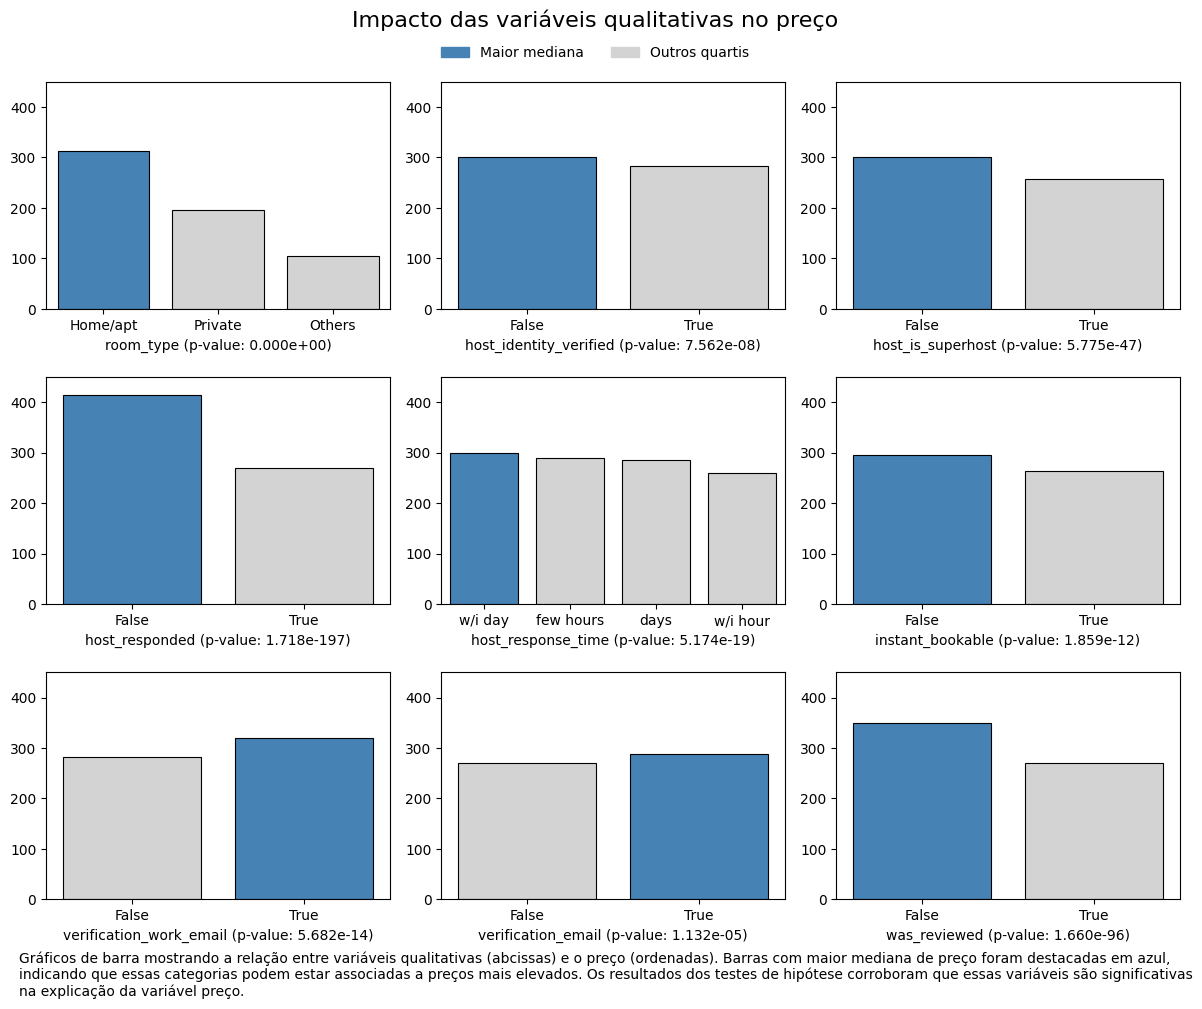

In [55]:
# Lista de variáveis qualitativas
variaveis_qualitativas = ['room_type', 'host_identity_verified', 'host_is_superhost', 'host_responded', 'host_response_time',
                          'instant_bookable', 'verification_work_email', 'verification_email', 'was_reviewed']

# Texto explicativo personalizado (opcional)
texto_explicativo = (
    "Gráficos de barra mostrando a relação entre variáveis qualitativas (abcissas) e o preço (ordenadas). "
    "Barras com maior mediana de preço foram destacadas em azul, indicando " 
    "que essas categorias podem estar associadas a preços mais elevados. "
    "Os resultados dos testes de hipótese corroboram que essas variáveis são "
    "significativas na explicação da variável preço."
)

ImpactoVariaveisQualitativas(df_correlacao, 'price', variaveis_qualitativas, texto_explicativo=texto_explicativo).plot()

## 5. Conclusão 

A análise exploratória de dados revelou variações significativas nos preços entre diferentes categorias das variáveis qualitativas, destacando a influência dessas variáveis na determinação dos preços. A aplicação de testes de hipótese confirmou que algumas categorias têm impacto estatisticamente significativo nos preços.

Na próxima etapa, em feature engineering, iremos criar e selecionar características relevantes para se usado em modelos de regressão, com a finalidade de melhor explicarmos o preço do Airbnb na cidade do Rio de Janeiro.